In [10]:
# actualizamos los modulos
%reload_ext autoreload
%autoreload 2

# imports
import df_info
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas import json_normalize
import json

# ruta
ruta_user_items = 'dataset/user_items.parquet'

# df
user_items_df = pd.read_parquet(ruta_user_items)

In [11]:
user_items_df.shape

(88310, 5)

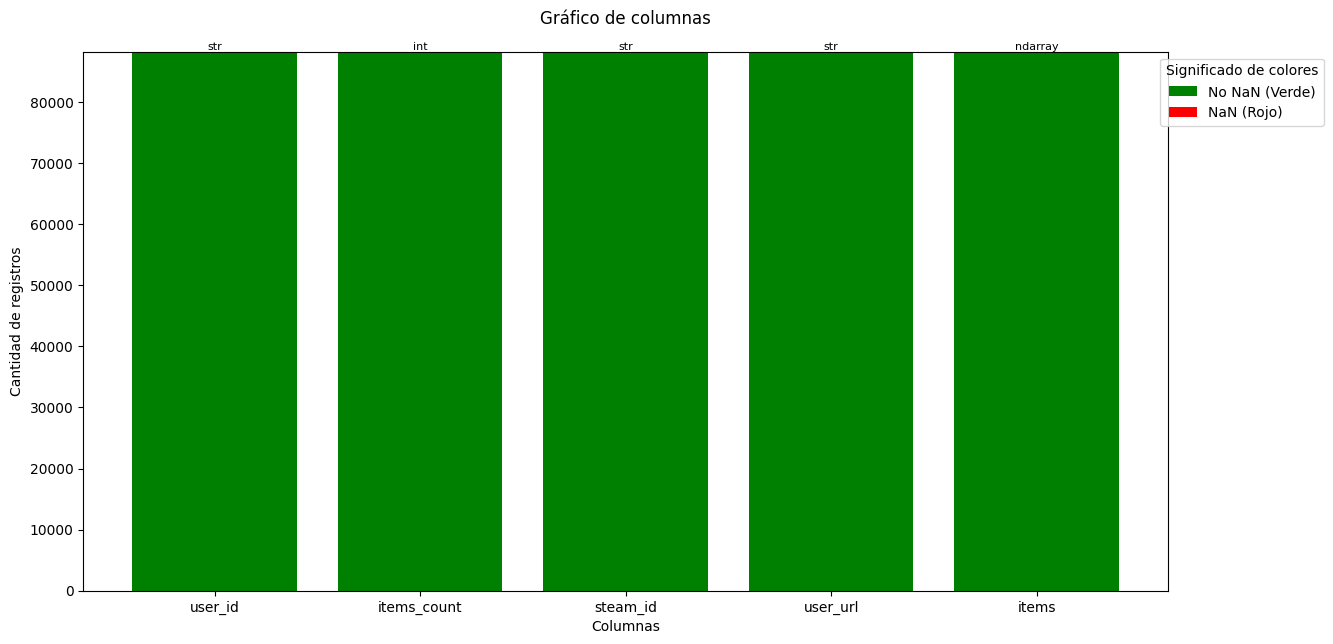

In [12]:
df_info.plot_df_info(user_items_df)

In [13]:
# Pasamos la columna items a tipo de dato lista para poder manipularla luego en la desanidación:
user_items_df['items'] = user_items_df['items'].apply(lambda x: x.tolist())

In [14]:
'''
Observamos un campo o columna que tiene datos anidados, que con un explode podríamos generar una tabla nueva con esa infromación,
pero antes vamos a explorar la posibilidad, y siendo que no existen datos nulos, que haya datos duplicados, si bien no podremos
hacer nada con ello hasta despues del explode, debido a que analizar registro por registro nos haria tener que iterar la columna,
accion que con el explode igualmente deberiamos hacer, solo que va a ser mucho mas comodo iterar sobre columnas, que sobre una 
columna con arrays, y dentro de los arrays.
'''

'\nObservamos un campo o columna que tiene datos anidados, que con un explode podríamos generar una tabla nueva con esa infromación,\npero antes vamos a explorar la posibilidad, y siendo que no existen datos nulos, que haya datos duplicados, si bien no podremos\nhacer nada con ello hasta despues del explode, debido a que analizar registro por registro nos haria tener que iterar la columna,\naccion que con el explode igualmente deberiamos hacer, solo que va a ser mucho mas comodo iterar sobre columnas, que sobre una \ncolumna con arrays, y dentro de los arrays.\n'

In [15]:
duplicados_agrupados = user_items_df.sort_values(by='user_id')\
                                     .loc[user_items_df.duplicated(subset=['user_id'], keep=False)]
duplicados_agrupados

,user_id,items_count,steam_id,user_url,items
29193,05041129,35,76561198167088451,http://steamcommunity.com/id/05041129,"[{'item_id': '4000', 'item_name': 'Garry's Mod..."
11000,05041129,35,76561198167088451,http://steamcommunity.com/id/05041129,"[{'item_id': '4000', 'item_name': 'Garry's Mod..."
37062,10outof10matee,56,76561198050688208,http://steamcommunity.com/id/10outof10matee,"[{'item_id': '220', 'item_name': 'Half-Life 2'..."
37061,10outof10matee,56,76561198050688208,http://steamcommunity.com/id/10outof10matee,"[{'item_id': '220', 'item_name': 'Half-Life 2'..."
6163,111222333444555666888,52,76561198082607692,http://steamcommunity.com/id/11122233344455566...,"[{'item_id': '240', 'item_name': 'Counter-Stri..."
...,...,...,...,...,...
16405,youseeitnowgetout,5,76561198087136132,http://steamcommunity.com/id/youseeitnowgetout,"[{'item_id': '230410', 'item_name': 'Warframe'..."
3473,zandado,107,76561198057890701,http://steamcommunity.com/id/zandado,"[{'item_id': '20', 'item_name': 'Team Fortress..."
34176,zandado,107,76561198057890701,http://steamcommunity.com/id/zandado,"[{'item_id': '20', 'item_name': 'Team Fortress..."
12417,zeroblade,306,76561197970272666,http://steamcommunity.com/id/zeroblade,"[{'item_id': '18110', 'item_name': 'Shattered ..."


Existen duplicados

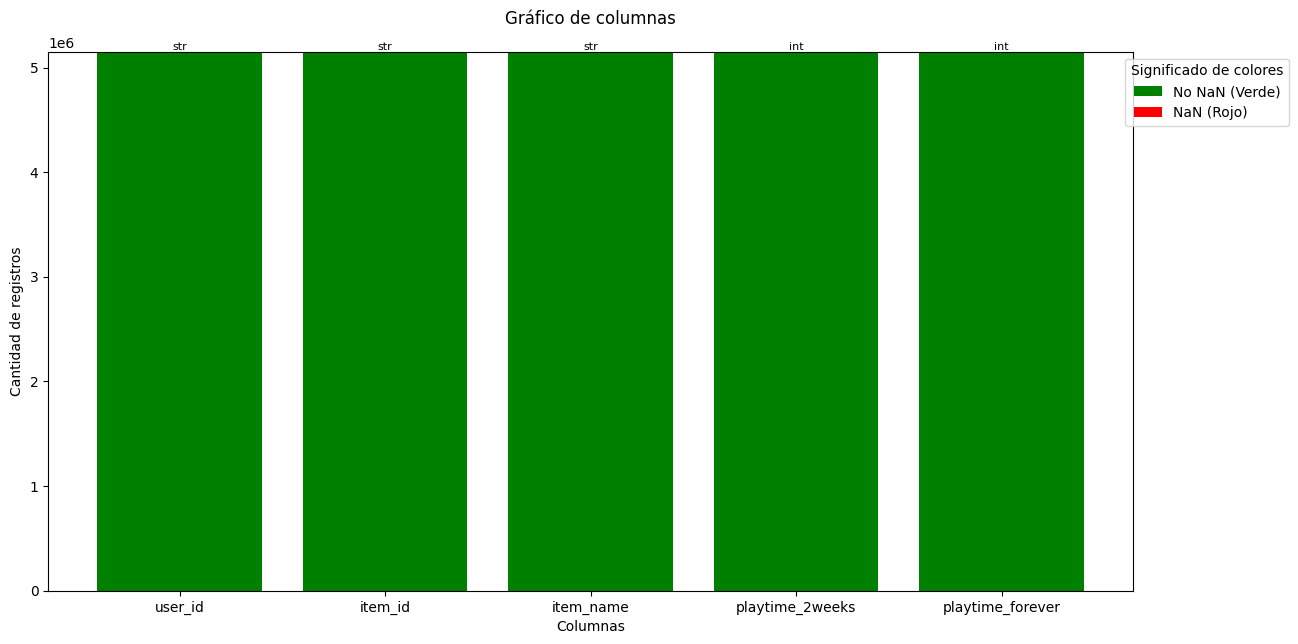

In [16]:
#explode
# Inicializar una lista para almacenar los registros expandidos
expanded_data = []

# Iterar sobre cada fila del DataFrame
for index, row in user_items_df.iterrows():
    items_list = row['items']
    
    # Verificar si la lista de items está vacía
    if items_list:
        user_id = row['user_id']
        # Iterar sobre cada diccionario en la lista de items
        for item_dict in items_list:
            # Crear un nuevo registro con el mismo user_id y los valores del diccionario
            new_record = {'user_id': user_id}
            new_record.update(item_dict)  # Agregar valores del diccionario al nuevo registro
            expanded_data.append(new_record)

# Crear un nuevo DataFrame a partir de los registros expandidos
exploded_df = pd.DataFrame(expanded_data)

df_info.plot_df_info(exploded_df)

In [ ]:
'''
comentario para seguir despues: Una vez gestado el explode, necesito verificar que la data obtenida es consistente. Vamos a generar una columna calculada a
partir de la columna items, que tenga en booleano o binario, false si la lista esta vacia, true en caso contrario, luego borraremos la columna items y 
separaremos a los usuarios en 2, los que contenian al menos un item en la columna items, y los que no, y comprobaremos de ambos grupos si existen registros
con ese usuario en mi dataframe producto del explode, y todo estara en orden todos los del grupo true estan contenidos, y los de false ninguno. Luego 
eliminaremos duplicados de nuestro segundo df y haremos un count de las filas, que es el resultado a cuantos items hay en total, luego en mi primer df 
haremos un sum de la columna items_count y tiene que ser igual a la cantidad de filas de nuestro segundo df. De no ser consistente, tenemos que ver cuantos
usuarios con el mismo user_id hay, sin que necesariamente sea toda la fila duplicada, y agrupar nuestro df resultante por user_id, para ver si tenemos 
duplicados que no hayamos podido deshacernos previamente, y evaluar cual de los datos imputados es el correcto, tambien en el agrupamiento por user_id de 
nuestro segundo dataframe podriamos hacer un sum de los groups para ver cuantos items, sin repetir tiene el usuario, y buscar tambien si hay duplicados por
item_id
'''

In [17]:
# Creamos columna que comprueba si el usuario tiene al menos item registrado o no:
user_items_df['has_items'] = user_items_df['items'].apply(lambda x: True if x else False)

In [22]:
# Eliminamos columna items
user_items_df.drop(columns=['items'], inplace=True)


In [ ]:
# Crear un conjunto de usuarios con has_items False
false_users_set = set(user_items_df[user_items_df['has_items'] == False]['user_id'])

# Crear un conjunto de usuarios con has_items True
True_users_set = set(user_items_df[user_items_df['has_items'] == True]['user_id'])